# Imports

Remember to run this!

This is required to import the required packages!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch
import torch.nn as nn
import cv2
import pickle
import csv
import json
from PIL import Image
import torch.nn.functional as F
import clip
from clip.model import AttentionPool2d
from clip.model import ModifiedResNet
from tqdm.auto import tqdm
from typing import Tuple, Union
from clip.model import CLIP
from clip.model import convert_weights
from torchvision.ops import generalized_box_iou_loss
from torchvision.ops.boxes import box_convert
import random
from typing import Iterator
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In this section, the **RefCOCOg** dataset is loaded and the tree splits are generated:
- `training_data`: split used to train the model, length: **80512**
- `validation_data`: split used to validate the model during training, length: **4896**
- `test_data`: split used to test the model after training, length: **9602**

Total: **95010**

The splits include exactly all samples from the dataset. This generates a very big training dataset that, due to computational limits, cannot be effectively exploited to fine tune the model to perfection.
Notice that the images in the dataset are around **25000**. The dataset size however is this big since each prompt, associated to the same image has been treated as a separated sample.

The training process has not been carried out on all the train data, due to computational and time limits.

**The path of the dataset must be adjusted based on the location of the dataset folder!**

In [2]:
# adjust based on the location of the dataset folder!
refcocog_path =  "E:/DL_Datasets/refcocog"

Load the pickle file and the instances json file

In [3]:
pick = pickle.load(open(refcocog_path+"/annotations/refs(umd).p", "rb"))
jsn = json.load(open(refcocog_path+"/annotations/instances.json", "rb"))

In [4]:
# set of all images
images_set = {}
for i in jsn['images']:
  image_id = i['id']
  images_set[image_id] = i

# set of all annotations
annotations_set = {}
for a in jsn['annotations']:
  annotation_id = a['id']
  annotations_set[annotation_id] = a

# set of all categories
# categories_set = {}
# for c in jsn['categories']:
#   category_id = c['id']
#   categories_set[category_id] = c

**Build dataset splits**

In [5]:
train_data, train_label       = [], []
validate_data, validate_label = [], []
test_data, test_label         = [], []

for p in pick:
    data_image_path = f"{refcocog_path}/images/{images_set[p['image_id']]['file_name']}"
    data_sentences = p['sentences']
    data_bbox = annotations_set[p['ann_id']]['bbox']

    data = []

    for s in data_sentences:
        sentence = s['sent']
        data.append([data_image_path, sentence, data_bbox])

    if p['split'] == 'train':
        train_data.extend(data)
    elif p['split'] == 'test':
        test_data.extend(data)
    elif p['split'] == 'val':
        validate_data.extend(data)

print(f"train {len(train_data)}, validation {len(validate_data)}, test {len(test_data)}")

train 80512, validation 4896, test 9602


### Dataset utils methods

In [6]:

def draw_box_on_image(image,size, bbox, color):
    w, h = size
    p1 = (int(bbox[0]*w), int(bbox[1]*h))
    p2 = (int((bbox[0]+bbox[2])*w), int((bbox[1] + bbox[3])*h))
    cv2.rectangle(image, p1, p2, color, 3)

def compute_target_heatmap(image, box):
    img_w, img_h = image.size
    x1 = int((box[0]) / img_w * 224)
    y1 = int((box[1]) / img_h * 224)
    x2 = int((box[0] + box[2]) / img_w * 224)
    y2 = int((box[1] + box[3]) / img_h * 224)

    target = torch.zeros((224, 224))
    target[y1:y2+1, x1:x2+1] = 1
    return target

def get_batch_data(batch, image_augment=False, augment_p=0.25):
    images, target_boxes, prompts, target_heatmaps = [], [], [], []
    for image_path, prompt, box in batch:
        image = Image.open(image_path).convert("RGB")
        w, h = image.size
        if image_augment and random.random()<augment_p:
            augment_transform = transforms.Compose([
                transforms.ColorJitter(brightness=(0.1,0.6), contrast=(0.4, 1),saturation=(0, 0.4), hue=(-0.5, 0.5))
            ])
            image = augment_transform(image)
            
        correct_box = [box[0] / w, box[1] / h, box[2] / w, box[3] / h]
        target_boxes.append(correct_box)
        images.append(image)            
        prompts.append(prompt)        
        target_heatmaps.append(compute_target_heatmap(image, box))    
    target_boxes = torch.tensor(target_boxes).to(device)
    target_boxes.requires_grad=False
    target_heatmaps = torch.stack(target_heatmaps).to(device)
    target_heatmaps.requires_grad=False
    return images, prompts, target_boxes, target_heatmaps

def view_image_with_bbox(image_path, prompt, bbox):
    image = Image.open(image_path).convert("RGB")
    w, h = image.size
    image = np.asarray(image)

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    print(bbox)
    print(f"normalized: {[bbox[0]/w, bbox[1]/h, bbox[2]/w, bbox[3]/h]}")
    print(f"p1 {p1}, p2 {p2}")
    cv2.rectangle(image, p1, p2, (0,255,255), 3)

    plt.imshow(image)
    plt.title(prompt)
    plt.show()


# Baseline

In the following section there is the implementation of the baseline method suggested, using YOLO as bounding box extractor.

The pipeline is to feed the image to YOLO that returns a set of bounding boxes.

Each subimage corresponding to each bounding box is extracted and then the similarity between the CLIP's encoding of the subimage and the prompt is computed.
The bounding box with the highest similarity is returned as output.

- **GIoU**: `0.574`


### Code

In [7]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
execute_baseline = False

Using cache found in C:\Users\matteo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-7-7 Python-3.11.3 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [8]:
if execute_baseline:

    base_clip, base_clip_preprocess = clip.load("RN50")
    losses = []

    for idx, data in enumerate(tqdm(test_data)):
        image_path, prompt, target_box = data
        image =  Image.open(image_path).convert("RGB")

        image_copy = np.asarray(image)
        cropped_images = []

        yolo_boxes = yolo_model(image_path).xyxy[0]

        # when yolo returns no prediction, just use the whole thing as bbox
        if len(yolo_boxes) == 0:
            target_tensor = torch.tensor(target_box).cuda()
            target_tensor = box_convert(target_tensor, in_fmt="xywh", out_fmt="xyxy")

            h, w = image.size
            ans = torch.tensor([0, 0, h, w])

            loss = generalized_box_iou_loss(ans, target_tensor)
            losses.append(loss.item())

            continue

        for yolo_box in yolo_boxes:
            x1, y1, x2, y2 = yolo_box[:4]
            x1 = int(x1); y1 = int(y1); x2 = int(x2); y2 = int(y2)

            cropped_image = image_copy[y1:y2, x1:x2]
            cropped_images.append(cropped_image)

            # plt.imshow(np.asarray(cropped_image))
            # plt.show()

        preprocessed_images = []
        for img_np in cropped_images:
            img = Image.fromarray(img_np)
            preprocessed_image = base_clip_preprocess(img)
            preprocessed_images.append(preprocessed_image)

        cropped_image_tensors = torch.stack(preprocessed_images).cuda()

        text_tokens = clip.tokenize(prompt).cuda()
        text_tokens.shape

        with torch.no_grad():
            image_features = base_clip.encode_image(cropped_image_tensors).float()
            text_features = base_clip.encode_text(text_tokens).float()

        # divide by norm
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = torch.matmul(image_features, text_features.T)
        similarity

        ans = similarity.argmax()
        ans = yolo_boxes[ans][:4]

        target_tensor = torch.tensor(target_box).cuda()
        target_tensor = box_convert(target_tensor, in_fmt="xywh", out_fmt="xyxy")

        loss = generalized_box_iou_loss(ans, target_tensor)
        losses.append(loss.item())

    # print(losses)

    print(f"GIoU: {sum(losses) / len(losses)}")

# Model

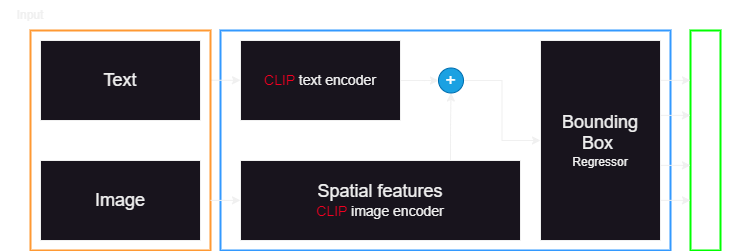

The architecture proposed, is inspired by the recent work: [Adapting CLIP For Phrase Localization Without Further Training](https://arxiv.org/abs/2204.03647) by _Jiahao Li, Greg Shakhnarovich, Raymond A. Yeh_.

In their paper, the goal was to adapt the **CLIP** model to phrase localization, without the need of any further training. This goal is a perfect starting point in order to adapt their solution to out phrase grounding task for the project.

To begin with, we have taken the "backbone" model from their repository: https://github.com/pals-ttic/adapting-CLIP.
The code borrowed includes the modification of the ResNet of CLIP in order to introduce, in the last layer, a spatial attention layer.
The goal is to adapt the CLIP model for phrase localization and, since CLIP effectively acts as an image and text embedder, there is the need to adapt the model to introduce spatial reasoning.
The steps are:
- Extract spatial features **mantaining their semantic meaning** (alignment with text)
- Compute the inner product with the text embedding, effectively generating a score map (heatmap)

-----

##### Single stage model

Many proposed methods that attempts to perform transfer learning to phrase localization and grounding starting from famous conv networks such as Fast-RCNN or Mask-RCNN, implements a what is called **two step models** [2].

Two stage models entails the use of an external feature extractor such as a Convolutional neural network that usually performs object detection and is able to extract bounding boxes.
These candidates boxes are then fed to the CLIP image encoder and compared with the encoding of the prompt, outputting the box with the highest score.
These solutions have an important caveat: since the CLIP encoding is compared with the subimage composed of the bounding box only, spatial reasoning is not included into the model.

The proposed method can be instead considered a **one stage model**.
Apart from the performance that we were able to achieve, the model should in theory be able to convey the spatial reasoning into the box regressor.
As shown below, the CLIP model is slightly modified in order to include this feature. This is the reason why the model is able to infer the heatmaps with quite remarkable accuracy.


It is worth noticing that, although the heatmaps are extracted with the `ResNetHighResV2` model and fed into the `HeatmapToBox` regressor, the framework can be considered as a single stage. 
Both the models could be infact unified in order to provide a single interface. This has not been done in order to better delineate the original contribution of the paper and our contribution.

### Custom Spatial CLIP

In this cells, the code inspired from **Adapting CLIP For Phrase Localization Without Further Training** is introduced.
It includes the customized `AttentionSpatial2d` which basically introduces spatial attention.

The `ModifiedSpatialResNet` is a simple ResNet which includes the previously introduced `AttentionSpatial2d`.

Finally, the custom CLIP with the `ModifiedSpatialResNet` is defined.

The final method `build_feature_extractor_model` has the job of creating this customized CLIP and to enable **transfer learning** from CLIP by copying the relative weights into the custom model.

In [9]:
clip_model, clip_preprocess = clip.load("RN50",jit=False,device=device)

def linear(x, weight, bias):
    x = x.matmul(weight.t())
    x += bias
    return x

class AttentionSpatial2d(AttentionPool2d):
    """Edited attention pool layer to introduce spatial attention"""
    def __init__(self,
                 spacial_dim: int,
                 embed_dim: int,
                 num_heads: int,
                 output_dim: int = None):
        super().__init__(spacial_dim, embed_dim, num_heads, output_dim)

    def forward(self, x):
        n, c, h, w = x.shape
        x = x.reshape(n, c, h*w).permute(2, 0, 1) # NCHW -> (H*W)NC
        x = linear(x, self.v_proj.weight, self.v_proj.bias)
        x = linear(x, self.c_proj.weight, self.c_proj.bias)
        x = x.permute(1, 2, 0).reshape(n, -1, h, w) # (H*W)NC -> C(H*W)N -> (N, -1, H, W)
        return x

class ModifiedSpatialResNet(ModifiedResNet):
    """Modified resnet to include the edited attention pool layer"""
    def __init__(self,
                 layers,
                 output_dim,
                 heads,
                 input_resolution=224,
                 width=64):
        super().__init__(layers, output_dim, heads, input_resolution, width)

        self.attnpool = AttentionSpatial2d(
            input_resolution // 32, width * 32, heads, output_dim)

class CLIPSpatialResNet(CLIP):
    """Modified spatial CLIP including the spatial attention"""
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int):

        super().__init__(embed_dim, image_resolution, vision_layers, vision_width,
                         vision_patch_size, context_length, vocab_size,
                         transformer_width, transformer_heads, transformer_layers)

        # Override the visual model
        vision_heads = vision_width * 32 // 64
        self.visual = ModifiedSpatialResNet(layers=vision_layers,
                                            output_dim=embed_dim,
                                            heads=vision_heads,
                                            input_resolution=image_resolution,
                                            width=vision_width)        


    def forward(self, image):
        image = image.type(self.dtype)

        # pad image
        pad = 64
        pad = (pad, pad, pad, pad)
        padded_image = F.pad(image, pad, "constant", 0)

        # get features
        features = self.encode_image(padded_image)
        target_size_h, target_size_w = image.size(-2) // 32, image.size(-1) // 32

        # compute new pad size
        pad_h = (features.size(-2) - target_size_w) // 2
        pad_w = (features.size(-1) - target_size_w) // 2
        features = features[:, :, pad_h:pad_h+target_size_h, pad_w:pad_w+target_size_w]

        # interpolate back to 224*224
        features = F.upsample(features, size=(image.size(-2), image.size(-1)),
            mode="bilinear", align_corners=None) # 1*C*H*W

        return features
    

def build_feature_extractor_model(clip_model): 
    """"Instantiate the modified CLIP model and adapt weights"""
    # transfer learning: extract weights from CLIP
    clip_state_dict = clip_model.state_dict()
    # run [k for k in clip_state_dict if k.startswith("visual.layer2")] to see what's up
    counts: list = [len(set(k.split(".")[2] for k in clip_state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
    vision_layers = tuple(counts)
    vision_width = clip_state_dict["visual.layer1.0.conv1.weight"].shape[0]
    output_width = round(
        (clip_state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)

    vision_patch_size = None
    image_resolution = output_width * 32

    embed_dim = clip_state_dict["text_projection"].shape[1]
    context_length = clip_state_dict["positional_embedding"].shape[0]
    vocab_size = clip_state_dict["token_embedding.weight"].shape[0]
    transformer_width = clip_state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(
        k.split(".")[2] for k in clip_state_dict if k.startswith(f"transformer.resblocks")))

    model = CLIPSpatialResNet(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers)#.to(device)
    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in clip_state_dict:
            del clip_state_dict[key]

    #convert_weights(model)

    # False for the average filter layer.
    model.load_state_dict(clip_state_dict, strict=False)
    model.eval()
    if device == 'cpu':
        model.float()
    for param in model.parameters():
            param.requires_grad = False
    for param in model.visual.attnpool.parameters():
        param.requires_grad = True
    return model

### The Feature extractor: Heatmaps generator

Here, the actual feature extractor model is created.

The `ResNetHighResV2` model is responsible for taking as input images and prompts, generating the scoremaps (heatmaps).

> The model has been adapted and customized (V2) in order to enable batch computation of heatmaps, since in the original implementation of the paper, the model was able to accept single image and prompt.

-----
Example of an image and its corresponding heatmap. Notice that the heatmaps is _shrinked_ and normalized to a fixed width and height, nonetheless spatial reasoning is mantained.

`the white imac computer that is also turned on`


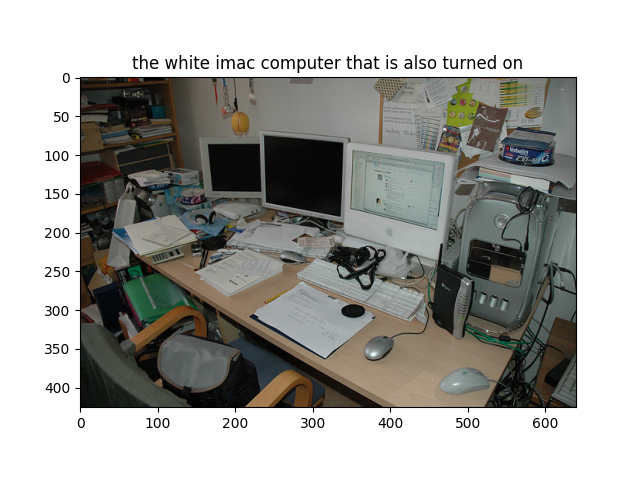 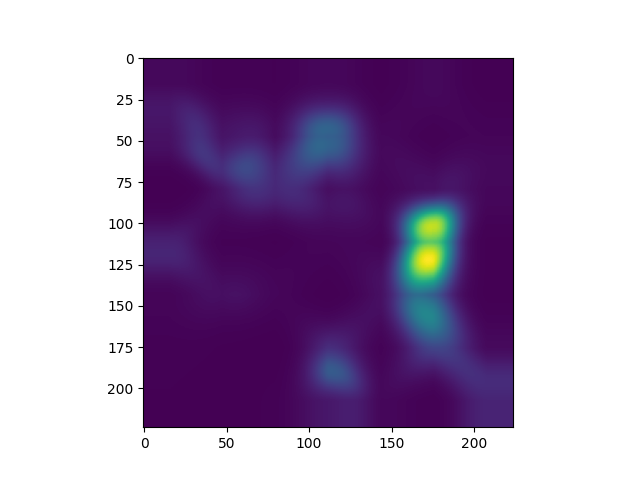

#### Generator

In [10]:
class ResNetHighResV2(nn.Module):
    """Feature extractor that includes CLIP as its fundation model"""
    def __init__(self, clip_preprocess, clip_model, tokenize, temperature=0.1, remap_heatmaps=True):
        super().__init__()
        self.spatial_model = build_feature_extractor_model(clip_model)
        self.clip_preprocess = clip_preprocess
        self.tokenize = tokenize
        self.temperature = temperature
        self.remap_heatmaps=remap_heatmaps        

    def get_image_features(self, images):
        images = [clip_preprocess(image) for image in images]
        images = torch.stack(images).to(device)
        image_features = self.spatial_model(images)
        return image_features

    def get_text_features(self, texts):
        tokenized_texts = self.tokenize(texts).to(device)
        text_features = self.spatial_model.encode_text(tokenized_texts)
        return text_features
    
    def get_heatmaps(self, image_features, text_features):
        # image_features /= image_features.norm(dim=1, keepdim=True)
        # (text_features / text_features.norm(dim=1, keepdim=True))
        heatmaps = ((image_features / image_features.norm(dim=1, keepdim=True)) * (text_features / text_features.norm(dim=1, keepdim=True))[:, :, None, None]).sum(1)
        # print(f"img features: {image_features.shape}")
        # print(f"txt features: {text_features.shape}")
        # print(f"heatmaps: {heatmaps.shape}")
        heatmaps = torch.exp(heatmaps/self.temperature)
        if self.remap_heatmaps:
            norm_heatmaps = torch.tensor(heatmaps)
            for i in range(len(heatmaps)):
                min = torch.min(heatmaps[i])
                #heatmaps[i] = -1 + 2 * (heatmaps[i] - min) / (torch.max(heatmaps[i])-min) + 1E-3
                norm_heatmaps[i] = (heatmaps[i] - min) / (torch.max(heatmaps[i])-min) + 1E-3    
            heatmaps = norm_heatmaps            
        heatmaps = heatmaps.pow(5)
        return heatmaps

    def forward(self, images, texts):
        image_features = self.get_image_features(images)
        text_features = self.get_text_features(texts)
        heatmaps = self.get_heatmaps(image_features, text_features)
        return heatmaps.squeeze(dim=1)
        #heatmaps = heatmaps.cpu().detach().float()
        #return heatmaps

### Bounding Box regressor

The following model is the **head** of all of our framework.

It takes as input the heatmaps generated by `ResNetHighResV2` and remapped by the `HeatmapRemapper` and regresses the four points of the bounding box in the form `(x, y, w, h)`.

It is worth noticing that this choice of a single bounding box regression without label is motivated by the fact that in the **RefCOCOg** dataset, each (image, prompt) is associated to a single bounding box.
Hence, since the job was to generate a phrase localization framework on the **RefCOCOg** dataset, the choice was to have a regressor that simply outputs a single box.

-----

The model effectively treats the heatmap as an image.

The first sequential layer is a series of `Conv2d` layers, that have the job to comprehend the spatial structure of the heatmap.

The second sequential layer is composed of an `AvgPool1d` that has the job to smooth the heatmap, followed by a **FFNN** that effectively regresses the four points.

In [11]:
class HeatmapToBox(nn.Module):
    """Custom model to regress a bounding box from an heatmap"""
    def __init__(self):
        super().__init__()  
        self.seq = nn.Sequential(                            
            nn.Conv2d(1,1,9,stride=1), 
            nn.Conv2d(1,1,7,stride=2), 
            nn.Conv2d(1,1,3,stride=2),
            
            nn.Flatten(),
            nn.AvgPool1d(4),

            nn.Linear(676, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.1),             
            nn.Sigmoid(), 

            nn.Linear(256, 128),  
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.1),          
            nn.Sigmoid(), 

            nn.Linear(128, 4),
            nn.Sigmoid(),    
            )
        print(f"bboxer parameters: {self.params_count()}")
         
    def params_count(self):
        c = 0
        for p in self.parameters():
            c += p.numel()
        return c

    def forward(self, x):   
        return self.seq(x.unsqueeze(dim=1))

# Training

The training process is divided into two:
- Finetuning the custom **Spatial CLIP**     
    This step aims in enforcing the spatial CLIP to generate good heatmaps. The loss is a `MSELoss` with respect to binary target heatmaps. These targets are basically heatmaps with the value 1 only on pixels inside the bounding box and 0 otherwise.
    The pipeline code is present below, however we noticed that finetuning even only the last layer of the `ModifiedResNet` model requires huge amount of computational time, even when other layers are frozen. Therefore extensive training is not been carried out.
    
- Training the **Box Regressor**     
    In this step we train our custom model to regress the actual bounding box


**Intersection Over Union**

The following function from `torchvision` calculates a gradient friendly version of the [Generalized Intersection Over Union](https://giou.stanford.edu/) and treats it as a loss, meaning that the `torch.Tensor` result is reduced to a single float that represents the average value for all the bounding boxes.

Boxes are converted from the **RefCOCOg** format to the format required by `torchvision`.

In [12]:
def iou(boxes1, boxes2) -> torch.Tensor:
    return generalized_box_iou_loss(box_convert(boxes1,in_fmt="xywh",out_fmt="xyxy"),box_convert(boxes2,in_fmt="xywh",out_fmt="xyxy"),reduction="mean")

**Training parameters**

In [13]:
train_size = 1024
train_batch_size = 16
epochs = 128
mini_train_data = train_data[:train_size]

validation_size = 128
validation_batch_size = 8
mini_val_data = validate_data[:validation_size]

test_size = 256
test_batch_size = 16
mini_test_data = test_data[:test_size]

#### Utility functions

In [14]:
import os

def evaluate_batch_routine(model, loss_fn, feature_extractor,data_batch, graphical=False, save=False):
    %matplotlib inline
    if save:
        try: 
            os.mkdir("imgs") 
        except OSError as error: 
            pass 
    model.eval()
    images, prompts, target_boxes, target_heatmaps = get_batch_data(data_batch)    
    with torch.no_grad():
        heatmaps = feature_extractor(images, prompts)
        prediction_boxes = model(heatmaps.to(device))
    c=0
    if graphical:
        for img, p, heatmap, correct, predicted in zip(images, prompts, heatmaps, target_boxes, prediction_boxes):
            size = img.size
            img_arr = np.asarray(img)
            draw_box_on_image(img_arr, size, predicted, (255,0,0))                    
            draw_box_on_image(img_arr, size, correct, (0,255,0))

            f = plt.figure(figsize=(12,6))
            plt.title(p)       
            plt.axis("off") 
            ax=f.add_subplot(1, 2, 1)
            ax.imshow(img_arr)
            ax.axis("off")
            ax=f.add_subplot(1, 2, 2)
            ax.imshow(heatmap.cpu())
            ax.axis("off")
            if save:
                plt.savefig(f"imgs/{c}.png")
            plt.show()
            c +=1 
            
        print(f"correct {correct}, predict: {predicted}")

    loss = loss_fn(prediction_boxes, target_boxes)
    return loss.item(), iou(prediction_boxes, target_boxes).item()

def training_routine(model, loss_fn, feature_extractor, optimizer):
    model.train()   
    epoch_loss =[]
    giou = []
    for i in tqdm(range(0, train_size, train_batch_size)):
        optimizer.zero_grad()

        batch_data = mini_train_data[i:i+train_batch_size]
        images, prompts, target_boxes, target_heatmaps = get_batch_data(batch_data)  
        with torch.no_grad():
            pred_heatmaps = feature_extractor(images, prompts)     
        prediction_boxes = model(pred_heatmaps)

        loss = loss_fn(prediction_boxes, target_boxes)      

        epoch_loss.append(loss.item())
        giou.append(iou(prediction_boxes, target_boxes).item())
        loss.backward()
        optimizer.step()

    return sum(epoch_loss) / len(epoch_loss), sum(giou) / len(giou)

def validation_routine(model, loss_fn, feature_extractor):
    model.eval()   
    epoch_loss =[]
    giou = []
    for i in tqdm(range(0, validation_size, validation_batch_size)):
        batch_data = mini_val_data[i:i+validation_batch_size]
        images, prompts, target_boxes, target_heatmaps = get_batch_data(batch_data)  
        with torch.no_grad():
            pred_heatmaps = feature_extractor(images, prompts)     
            prediction_boxes = model(pred_heatmaps)
            loss = loss_fn(prediction_boxes, target_boxes)      
            epoch_loss.append(loss.item())
            giou.append(iou(prediction_boxes, target_boxes).item())

    return sum(epoch_loss) / len(epoch_loss), sum(giou) / len(giou)

def finetune_clip_routine(loss_fn, feature_extractor, optimizer):
    epoch_loss =[]
    for i in range(0, train_size, train_batch_size):
        optimizer.zero_grad()
        batch_data = mini_train_data[i:i+train_batch_size]
        images, prompts, target_boxes, target_heatmaps = get_batch_data(batch_data)  
        heatmaps = feature_extractor(images, prompts) 
        rem_loss = loss_fn(heatmaps, target_heatmaps)
        epoch_loss.append(rem_loss.item())

        rem_loss.backward()
        optimizer.step()

    return sum(epoch_loss) / len(epoch_loss)

### Training Cycle

#### Finetuning the Spatial CLIP

In [15]:
feature_extractor = ResNetHighResV2(clip_preprocess, clip_model, clip.tokenize, remap_heatmaps=False, temperature=0.3).to(device)
loss_fn = nn.MSELoss()

In [16]:
finetune = False
if finetune:
    optimizer = torch.optim.Adam(params=feature_extractor.spatial_model.visual.attnpool.parameters(), lr=4E-6)
    feature_extractor.eval()
    feature_extractor.spatial_model.visual.attnpool.train()
    for epoch in range(epochs):
        loss = finetune_clip_routine(loss_fn ,feature_extractor, optimizer)
        print(f"epoch {epoch}")
        print(f"loss: {loss}")             
    optimizer.zero_grad(set_to_none=True)
    feature_extractor.eval()
    torch.save(feature_extractor, "extractor.pt")

In [17]:
#feature_extractor = torch.load("extractor.pt")

#### Training the box regressor

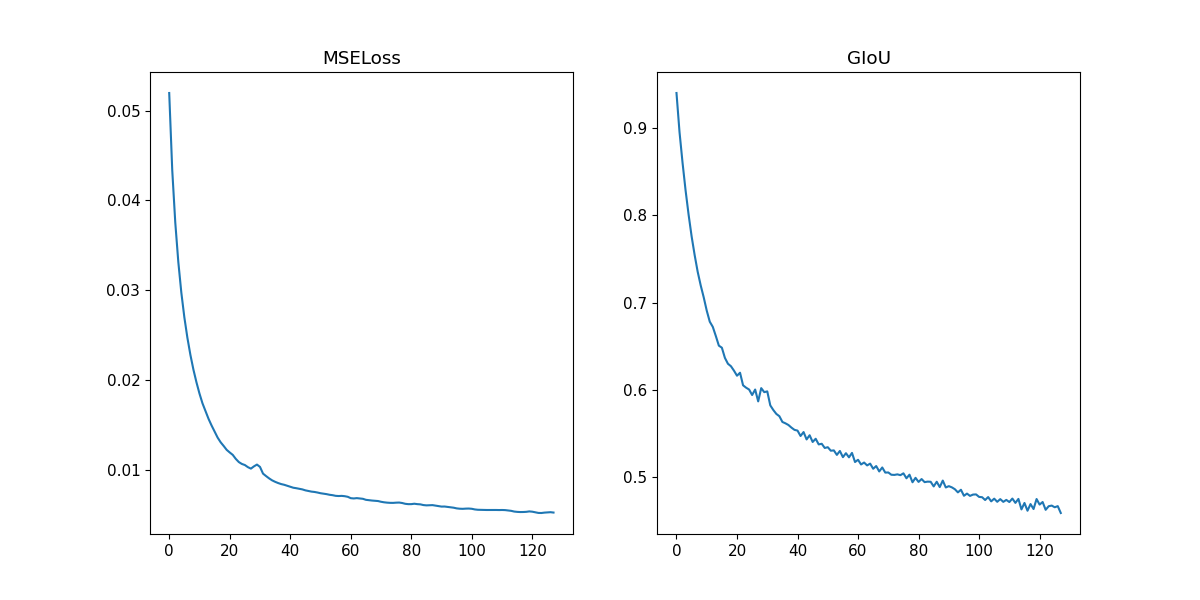

In [18]:
bboxer = HeatmapToBox().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=bboxer.parameters(), lr=1E-4)

bboxer parameters: 207634


In [ ]:
best = 1E3
best_giou = 1E4
val_loss = val_giou = 1E3
with open("training.csv", "w", newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(["epoch", "loss", "giou","val_loss","val_giou"])

for epoch in range(epochs):
    val_loss, val_giou = validation_routine(bboxer, loss_fn, feature_extractor)
    loss, giou = training_routine(bboxer, loss_fn, feature_extractor, optimizer)
    with open("training.csv", "a", newline="") as file:
        csvwriter = csv.writer(file)
        csvwriter.writerow([epoch, loss, giou, val_loss, val_giou])

    print(f"epoch {epoch} | loss {loss} | giou {giou} | val_loss {val_loss} | val_giou {val_giou}")
    
    if best_giou > val_giou:
        torch.save(bboxer, "checkpoint.pt")
        best_giou=val_giou     

In [ ]:
%matplotlib inline
df = pd.read_csv("training.csv")

f = plt.figure(figsize=(12,6))

ax=f.add_subplot(1, 2, 1)
ax.set_title("MSELoss")
ax.plot(df.epoch, df.loss)
ax.plot(df.epoch, df.val_loss)
ax.legend(["training","validation"], loc=3)

ax=f.add_subplot(1, 2, 2)
ax.set_title("GIoU")
ax.plot(df.epoch, df.giou)
ax.plot(df.epoch, df.val_giou)
ax.legend(["training","validation"], loc=3)

plt.savefig("losses.png")
plt.show()

**Save the model manually**

In [ ]:
torch.save(bboxer, "regressor.pt")

**Load the model**

In [ ]:
bboxer = torch.load("regressor.pt")

## Testing and evaluating

We noticed that the `HeatmapToBox` model is **highly dependant** on the quality of the heatmaps generated. If the heatmap is good, the training process is extremely faster and more effective.

This means that extensively training the Spatial CLIP model on the dataset would result is extremely better performance.

We didn't have the possibility to train the Spatial CLIP model on the dataset due to having finished the available hours of the Azure's server. This means that the regressor is extremely subjective to overfitting since we trained on very smallt raining data on our personal computers.

Nonetheless, the below results have been achieved on the training data without training the Spatial CLIP at all.

Although the examples are drawn from the data the model is trained on, it can be seen that the model is able to **effectively represent** the data, suggesting that further regressor training togheter with the training of the Spatial CLIP could result in very good performance.

-----

> The presented results have been achieved on the training set

- MSELoss: `5.7E-3`
- GIoU : `0.51`

-----

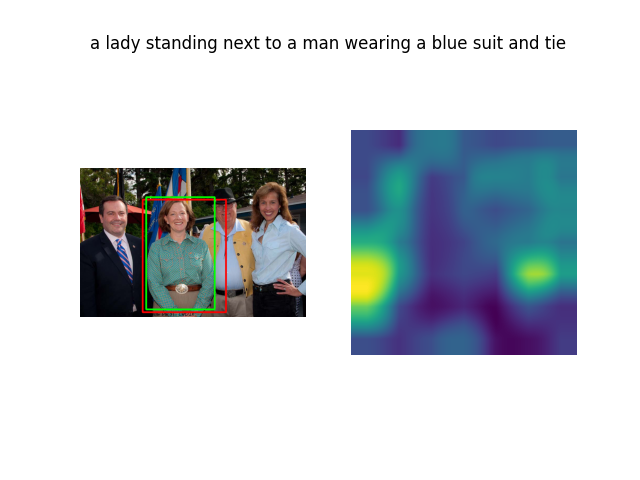
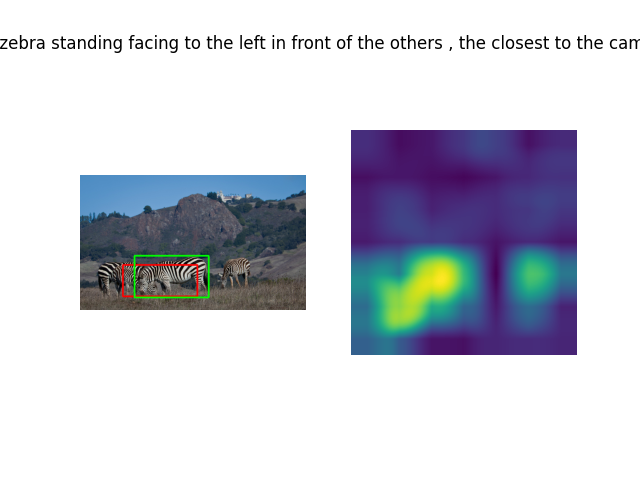
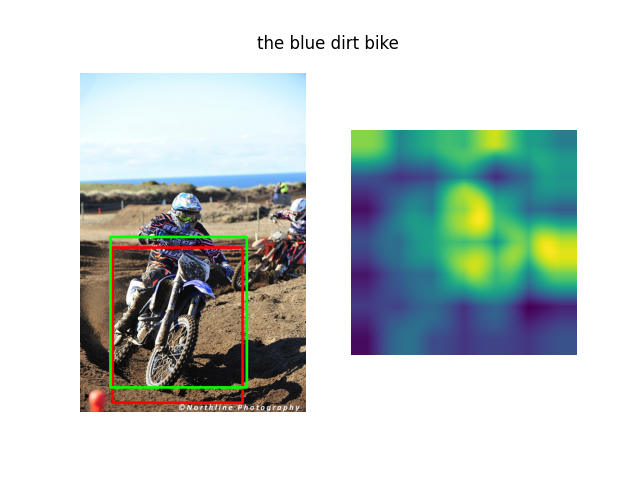
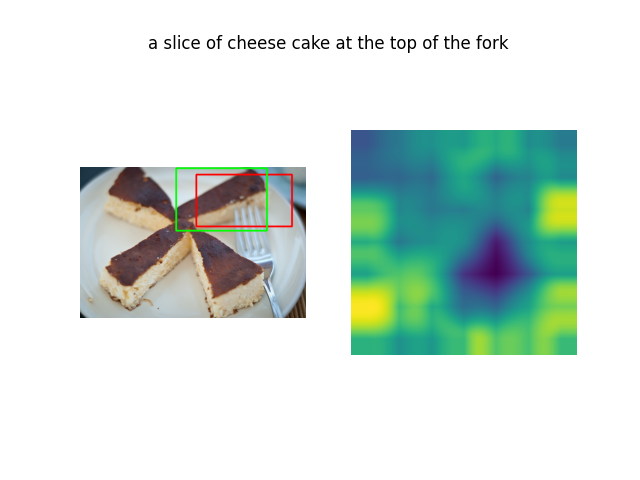

In [ ]:
def evaluate(start, end, batch_size, data, graphical=False):
    l = []
    io = []
    for i in tqdm(range(start, end, batch_size)):
        batch_data = data[i:i+batch_size]
        loss, giou = evaluate_batch_routine(bboxer, loss_fn, feature_extractor, batch_data, graphical=graphical)
        l.append(loss)
        io.append(giou)
    print(f"loss: {sum(l)/len(l)}, iou: {sum(io)/len(io)}")

Run on the whole training set

In [ ]:
evaluate(0, 4, 2, train_data, graphical=True)
#evaluate(0, validation_size, validation_batch_size, validate_data, graphical=False)
#evaluate(0, test_size, test_batch_size, test_data, graphical=False)

# Conclusions

The proposed model is interesting due to the following reasons:
- It is a **single stage model** to perform phrase grounding
- It enables the CLIP model to be used for phrase grounding
- The modularity of the framework enabled the head to be swapped extremely easily. This means that any head capable of regressing a bounding box from an heatmap in the proposed form can be attached
- It involves the possibility to finetune CLIP itself for the phrase grounding task

The performance achieved is due to many reasons. First of all the training data has not been exploited at its fullest. Due to time and computational power constraints, an extensive process of training could not be achieved.
However, training on relatively small training set demonstrated that the model is actually capable to regressing the bounding box with relatively good precision.

Specifically, the model was able to perfectly overfit small samples of the training data, demonstrating that its strucutre is able to actually represent the data samples in an efficient way.

## Future work and improvements

The model could be improved in the following ways:
- Extensive training on larger dataset, with better hardware resources
- Tweaks to the shape and the hyperparameters of the `HeatmapToBox` head model
- Finetuning the Spatial CLIP model itself in order to better adapt it to the target dataset

The results showed that potentially this structure may serve as a good fundation for phrase grounding framework that are able to adapt pretrained larger models such as CLIP for a specific task such as phrase grounding.

# Bibliography
- [1] [Adapting CLIP For Phrase Localization Without Further Training](https://arxiv.org/abs/2204.03647)
- [2] [A Fast and Accurate One-Stage Approach to Visual Grounding](https://arxiv.org/abs/1908.06354)
- [3] [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/abs/1207.0580)
- [4] [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)